In [1]:
# load dependecies
import cv2 # image procesing and computer vision
import numpy as np # mathematical and algebra 
import matplotlib.pyplot as plt # vizualization
import pytesseract as pt    # OCR image to data (text, and others)
from pytesseract import Output  # 
import nltk     # natural language processing
from nltk.tag.stanford import StanfordNERTagger # named entity recognition dependecy
import os   # 

# important, define your java.exe path
#java_path = java_path = "C:/Program Files/Java/jre1.8.0_251/bin/java.exe"
#os.environ['JAVAHOME'] = java_path

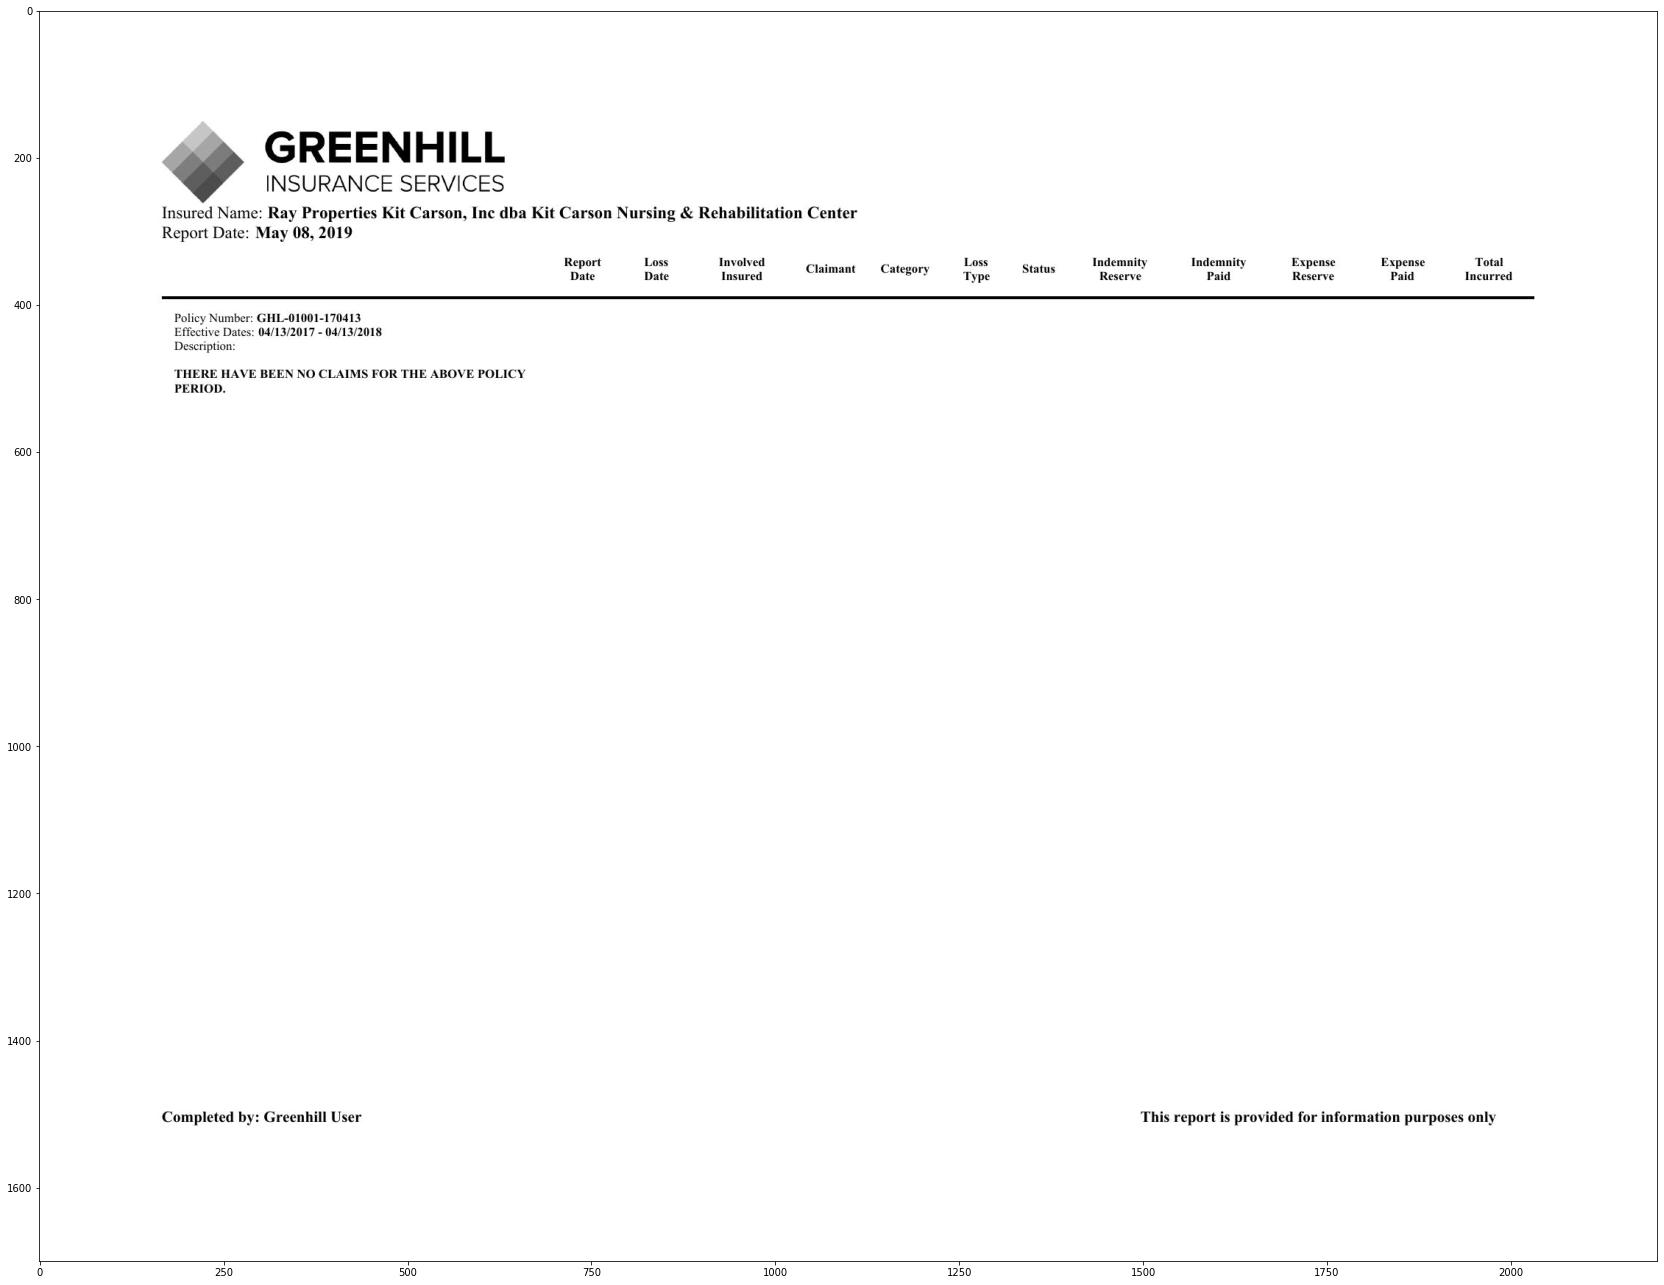

In [5]:
# load data

# select image
image_file = 'Loss Runs - Ray Properties Kit Carson, Inc dba Kit Carson Nursing & Rehabilitation Center - 2019-05-08.jpg'

# define the image path
image_path = os.path.join('.','.','data','images', image_file)

# read image in uint8 format
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# normalize image
# image = np.double(image) / 255.0

# visualize the data
plt.figure(figsize=(30,23))
plt.imshow(image, cmap = 'gray')


In [6]:
#Extract text from image
text = pt.image_to_string(image)

# Get the data of the image in dictionary form
image_to_data = pt.image_to_data(image= image, output_type=Output.DICT)

# Define path for 7 classes classifier
path_to_classifier = os.path.join('.','codes','stanford-ner-4.0.0','classifiers','english.muc.7class.distsim.crf.ser.gz')

# Define path to java application
path_to_java_app = os.path.join('.','codes','stanford-ner-4.0.0','stanford-ner.jar')

# Named Entity Recognition
st = StanfordNERTagger(path_to_classifier, path_to_java_app)

#
person, money, date = [], [], []

# clases founded in text 
for sent in nltk.sent_tokenize(text):
    tokens = nltk.tokenize.word_tokenize(sent)
    tags = st.tag(tokens)
    for tag in tags:
        if tag[1] == 'PERSON':
            # add the person to list
            person.append(tag[0])
        if tag[1] == 'MONEY':
            money.append(tag[0])

        if tag[1] == 'DATE':
            date.append(tag[0])

print('_'*50 + '\nNames: '), print(person)
print('_'*50 + '\nMoney involved: '), print(money)
print('_'*50 + '\nDates: '), print(date)

__________________________________________________
Names: 
[]
__________________________________________________
Money involved: 
[]
__________________________________________________
Dates: 
['May', '08', ',', '2019']


(None, None)

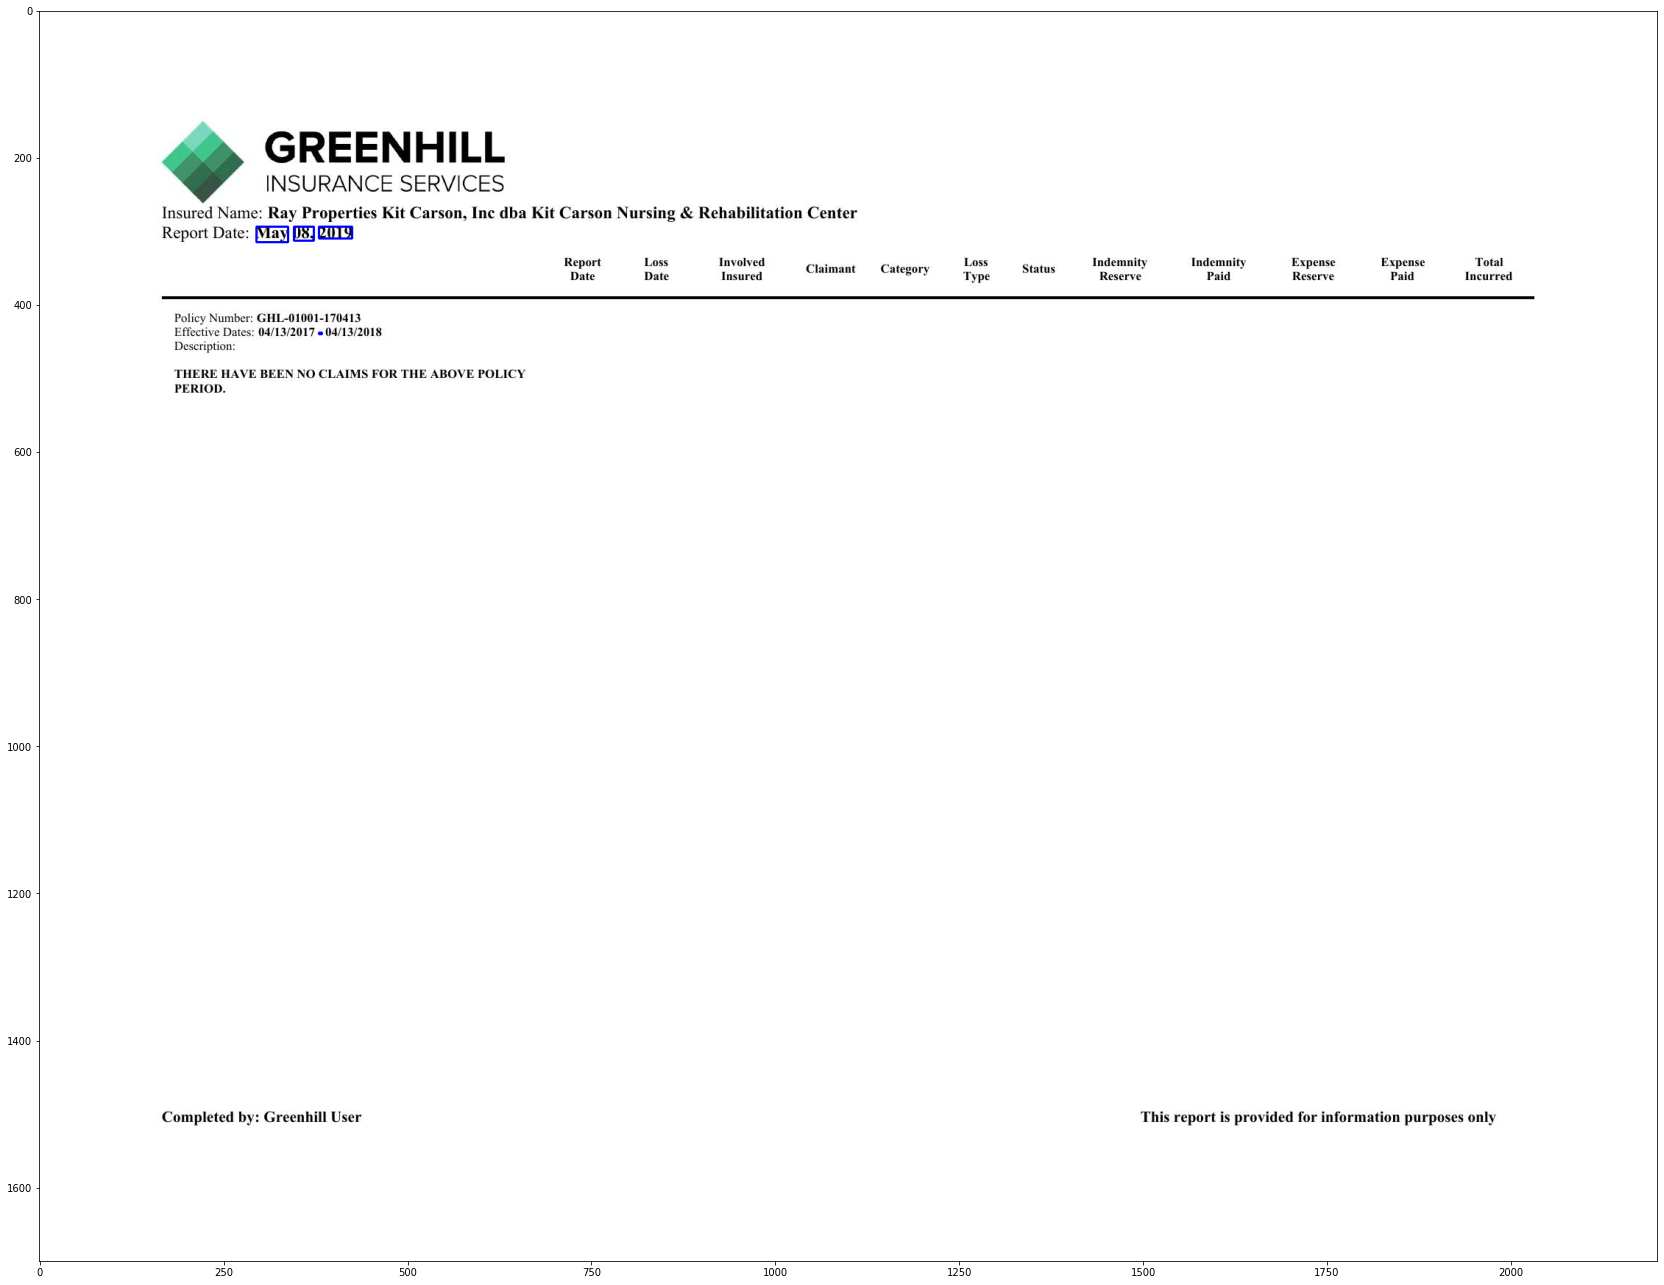

In [8]:
image_color = cv2.imread(image_path)
 ## Create a new dict with no empty spaces
labels = st.tag(image_to_data['text'])
# get the non empty spaces index
filter = (lambda dic, key, val: [i for i in range(len(dic[key])) if dic[key][i] != val])
index_filtered = filter(dic = image_to_data, key = 'text', val = '')

for i in range(len(index_filtered)-1):
    if labels[i][1] == 'PERSON':
        (x_1, y_1, x_2, y_2) = (image_to_data['left'][index_filtered[i]], image_to_data['top'][index_filtered[i]],
                            image_to_data['width'][index_filtered[i]], image_to_data['height'][index_filtered[i]])
        image = cv2.rectangle(image_color, (x_1, y_1), (x_1 + x_2, y_1 + y_2), (0, 255, 0), 2)
    elif labels[i][1] == 'MONEY':
        (x_1, y_1, x_2, y_2) = (image_to_data['left'][index_filtered[i]], image_to_data['top'][index_filtered[i]],
                            image_to_data['width'][index_filtered[i]], image_to_data['height'][index_filtered[i]])
        image = cv2.rectangle(image_color, (x_1, y_1), (x_1 + x_2, y_1 + y_2), (255, 0, 0), 2)
    elif labels[i][1] == 'DATE':
        (x_1, y_1, x_2, y_2) = (image_to_data['left'][index_filtered[i]], image_to_data['top'][index_filtered[i]],
                            image_to_data['width'][index_filtered[i]], image_to_data['height'][index_filtered[i]])
        image = cv2.rectangle(image_color, (x_1, y_1), (x_1 + x_2, y_1 + y_2), (0, 0, 255), 2)

plt.figure(figsize=(30,23))
plt.imshow(image_color)

In [2]:
!pip list

/usr/bin/sh: 1: pip: not found
